In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

data = pd.read_csv("/kaggle/input/mri-and-alzheimers/oasis_cross-sectional.csv")
# remove columsn with NaN
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

data = pd.read_csv("/kaggle/input/mri-and-alzheimers/oasis_cross-sectional.csv")
data.head(4)
columns2select = ["M/F", "Age", "eTIV", "nWBV", "ASF"]
categorical_columns = ["M/F", "Hand"]
numerical_columns = ["Age", "eTIV", "nWBV", "ASF"]
data = data[columns2select]
data = data.dropna()
data

,M/F,Age,eTIV,nWBV,ASF
0,F,74,1344,0.743,1.306
1,F,55,1147,0.810,1.531
2,F,73,1454,0.708,1.207
3,M,28,1588,0.803,1.105
4,M,18,1737,0.848,1.010
...,...,...,...,...,...
431,M,20,1469,0.847,1.195
432,M,22,1684,0.790,1.042
433,M,22,1580,0.856,1.111
434,F,20,1262,0.861,1.390


## CTGAN

In [2]:
from IPython.display import clear_output
!pip install ctgan
clear_output()

In [20]:
from ctgan import CTGAN
categorical_columns = ["M/F"]
ctgan = CTGAN(epochs=1000)
ctgan.fit(data, categorical_columns)

In [21]:
NUM_GENERATED_SAMPLES = 400
synthetic_data = ctgan.sample(NUM_GENERATED_SAMPLES)
print(synthetic_data.head())

  M/F  Age  eTIV      nWBV       ASF
0   M   64  1691  0.857805  0.971158
1   F   19  1539  0.838537  1.043434
2   M   23  1467  0.853495  1.136523
3   M   72  1471  0.731657  1.065020
4   F   87  1483  0.704385  1.175854


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, chi2_contingency

class TabularDataComparator:
    def __init__(self, real_df: pd.DataFrame, synth_df: pd.DataFrame):
        """
        Initialize comparator with real and synthetic datasets.
        Both must be pandas DataFrames with the same columns.
        """
        self.real = real_df.reset_index(drop=True)
        self.synth = synth_df.reset_index(drop=True)

    def summary_statistics(self):
        """
        Return summary statistics for real and synthetic datasets,
        including mean, std, min, max, quartiles, skewness, and kurtosis.
        """
        real_stats = self.real.describe().T
        synth_stats = self.synth.describe().T
    
        # Add skewness and kurtosis
        real_stats["skewness"] = self.real.skew(numeric_only=True)
        real_stats["kurtosis"] = self.real.kurt(numeric_only=True)
        synth_stats["skewness"] = self.synth.skew(numeric_only=True)
        synth_stats["kurtosis"] = self.synth.kurt(numeric_only=True)
    
        return real_stats, synth_stats

    def ks_test(self):
        """Kolmogorov-Smirnov test for numeric columns."""
        results = []
        for col in self.real.select_dtypes(include=np.number).columns:
            stat, pval = ks_2samp(self.real[col], self.synth[col])
            results.append({"Column": col, "KS Statistic": stat, "p-value": pval})
        return pd.DataFrame(results)

    def plot_distributions(self, columns=None, bins=30, name="normal"):
        """Plot histograms for numeric columns."""
        #if columns is None:
        columns = self.real.select_dtypes(include=np.number).columns

        for col in columns:
            plt.figure(figsize=(7, 5))
            #sns.histplot(self.real[col], bins=bins, color="blue", label="Real", stat="density", alpha=0.5)
            #sns.histplot(self.synth[col], bins=bins, color="red", label="Synthetic", stat="density", alpha=0.5)
            plt.hist(self.real[col], bins=bins, label="Real", alpha=0.5)
            plt.hist(self.synth[col], bins=bins, label="Synthetic", alpha=0.5)
            #plt.title(f"Distribution of {col}")
            #plt.xlabel(col)
            plt.ylabel("Density", fontsize=18)
            plt.legend(fontsize=18)
            plt.tick_params(axis='both', labelsize=20)
            plt.savefig(name+"_"+col+"_dis.pdf", bbox_inches='tight')
            plt.show()
            

    def plot_correlation(self, name="normal"):
        """Compare correlation matrices of real vs synthetic data."""
        corr_real = self.real.corr(numeric_only=True)
        corr_synth = self.synth.corr(numeric_only=True)

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        sns.heatmap(corr_real, ax=axes[0], cmap="coolwarm", vmin=-1, vmax=1, annot=False)
        axes[0].set_title("Real Data Correlation")

        sns.heatmap(corr_synth, ax=axes[1], cmap="coolwarm", vmin=-1, vmax=1, annot=False)
        axes[1].set_title("Synthetic Data Correlation")
        fig.savefig(name+"_corr.pdf", bbox_inches='tight')
        plt.show()

    # ---------- Categorical Comparison ----------
    def chi_square_test(self):
        """
        Perform Chi-square test for each categorical column.
        Returns DataFrame with chi2 statistic, p-value.
        """
        results = []
        for col in self.real.select_dtypes(exclude=np.number).columns:
            freq_real = self.real[col].value_counts(normalize=True)
            freq_synth = self.synth[col].value_counts(normalize=True)

            # Align categories
            all_categories = set(freq_real.index).union(set(freq_synth.index))
            obs = pd.DataFrame({
                "real": [freq_real.get(cat, 0) for cat in all_categories],
                "synth": [freq_synth.get(cat, 0) for cat in all_categories]
            }, index=list(all_categories))

            chi2, pval, _, _ = chi2_contingency(obs.T)
            results.append({"Column": col, "Chi2 Statistic": chi2, "p-value": pval})
        return pd.DataFrame(results)

    def plot_categorical(self, columns=None, name="normal"):
        """Plot bar charts for categorical columns."""
        if columns is None:
            columns = self.real.select_dtypes(exclude=np.number).columns
        
        for col in columns:
            plt.figure(figsize=(7, 5))
            freq_real = self.real[col].value_counts(normalize=True).sort_index()
            freq_synth = self.synth[col].value_counts(normalize=True).sort_index()

            df_plot = pd.DataFrame({
                "Real": freq_real,
                "Synthetic": freq_synth
            }).fillna(0)

            df_plot.plot(kind="bar", alpha=0.7)
            plt.title(f"Categorical Distribution of {col}")
            plt.ylabel("Proportion", fontsize=18)
            plt.xticks(rotation=45)
            plt.legend(fontsize=18)
            plt.tick_params(axis='both', labelsize=20)
            plt.savefig(name+"_"+"_cat_corr.pdf", bbox_inches='tight')
            plt.show()
            

Real Data Summary:
       count         mean         std       min         25%       50%  \
Age   436.0    51.357798   25.269862    18.000    23.00000    54.000   
eTIV  436.0  1481.919725  158.740866  1123.000  1367.75000  1475.500   
nWBV  436.0     0.791670    0.059937     0.644     0.74275     0.809   
ASF   436.0     1.198894    0.128682     0.881     1.11175     1.190   

             75%       max  skewness  kurtosis  
Age     74.00000    96.000 -0.000483 -1.598821  
eTIV  1579.25000  1992.000  0.266392 -0.154097  
nWBV     0.84200     0.893 -0.520533 -0.882832  
ASF      1.28425     1.563  0.286110 -0.179317  

Synthetic Data Summary:
       count         mean         std          min          25%          50%  \
Age   400.0    38.375000   24.631507     9.000000    17.000000    25.000000   
eTIV  400.0  1517.457500  156.019722  1107.000000  1418.750000  1499.500000   
nWBV  400.0     0.800492    0.060635     0.634771     0.755269     0.816309   
ASF   400.0     1.166603    0.15

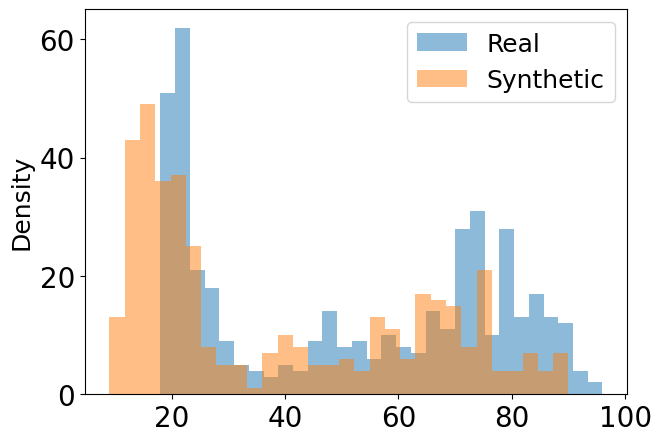

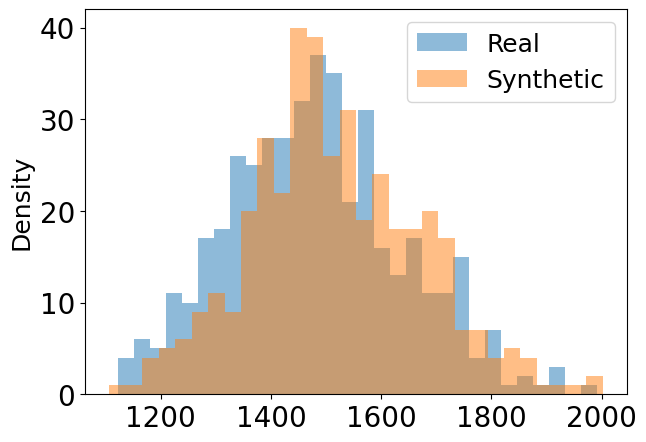

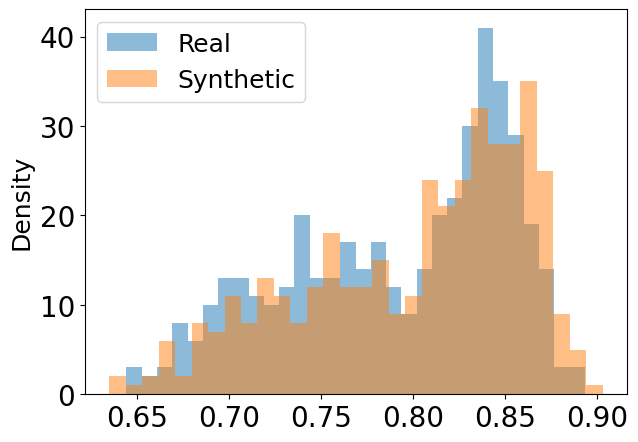

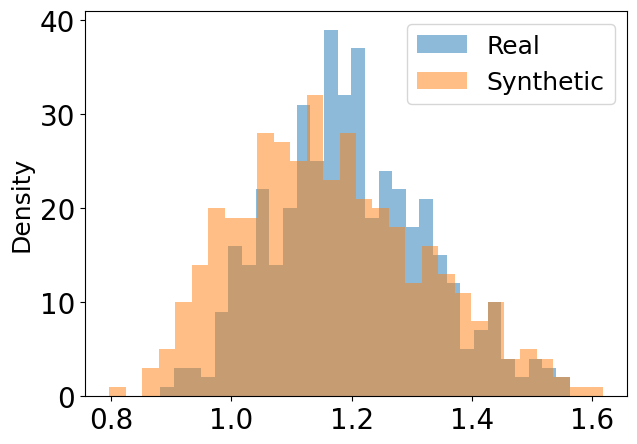

  Column  Chi2 Statistic  p-value
0    M/F             0.0      1.0


<Figure size 700x500 with 0 Axes>

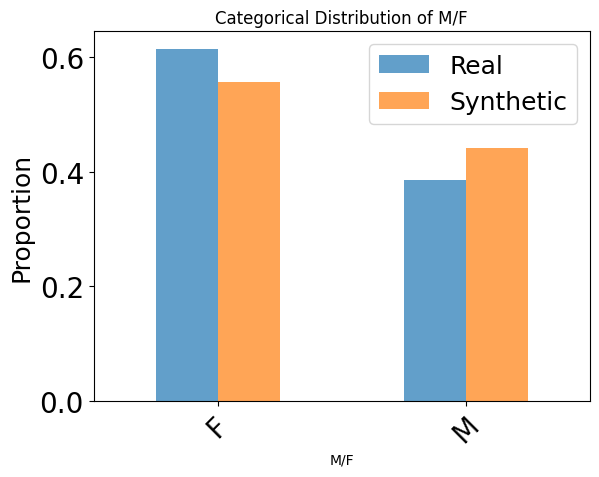

In [23]:
comp = TabularDataComparator(data, synthetic_data)

real_stats_1, synth_stats_1 = comp.summary_statistics()
print("Real Data Summary:\n", real_stats_1)
print("\nSynthetic Data Summary:\n", synth_stats_1)
print("\nKS Test Results:\n", comp.ks_test())

# Compare numeric
print(comp.ks_test())
comp.plot_distributions(name="model1")

# Compare categorical
print(comp.chi_square_test())
comp.plot_categorical(name="model1")

## TVAE

In [24]:
categorical_columns = ["M/F"]

from ctgan import TVAE
tvae = TVAE(epochs=1000)
tvae.fit(data, categorical_columns)

In [25]:
synthetic_data = ctgan.sample(NUM_GENERATED_SAMPLES)
print(synthetic_data.head())

  M/F  Age  eTIV      nWBV       ASF
0   M   18  1630  0.805929  1.036629
1   F   17  1439  0.782995  1.317966
2   F   77  1661  0.747648  1.219116
3   M   21  1450  0.746169  1.024230
4   F   52  1253  0.721652  1.163634


Real Data Summary:
       count         mean         std       min         25%       50%  \
Age   436.0    51.357798   25.269862    18.000    23.00000    54.000   
eTIV  436.0  1481.919725  158.740866  1123.000  1367.75000  1475.500   
nWBV  436.0     0.791670    0.059937     0.644     0.74275     0.809   
ASF   436.0     1.198894    0.128682     0.881     1.11175     1.190   

             75%       max  skewness  kurtosis  
Age     74.00000    96.000 -0.000483 -1.598821  
eTIV  1579.25000  1992.000  0.266392 -0.154097  
nWBV     0.84200     0.893 -0.520533 -0.882832  
ASF      1.28425     1.563  0.286110 -0.179317  

Synthetic Data Summary:
       count         mean         std          min          25%          50%  \
Age   400.0    38.127500   25.365326     1.000000    17.000000    24.000000   
eTIV  400.0  1522.307500  156.328002  1122.000000  1413.750000  1509.000000   
nWBV  400.0     0.800313    0.062159     0.625104     0.751606     0.818203   
ASF   400.0     1.166683    0.14

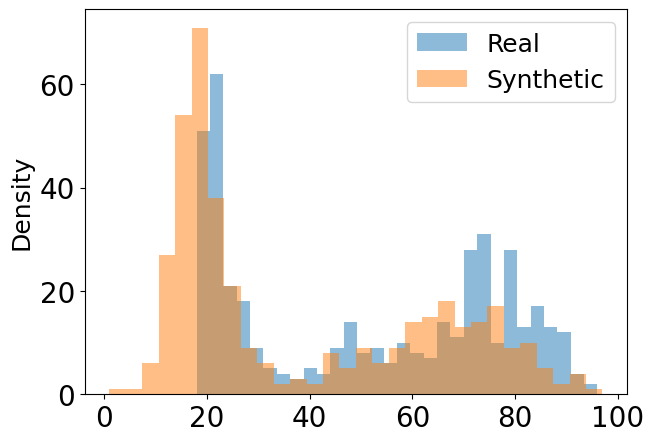

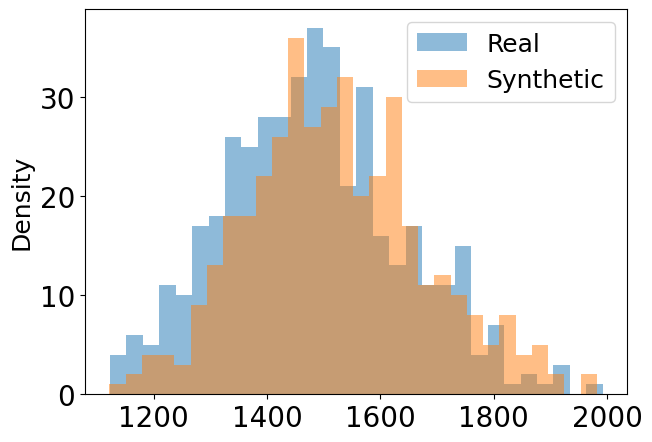

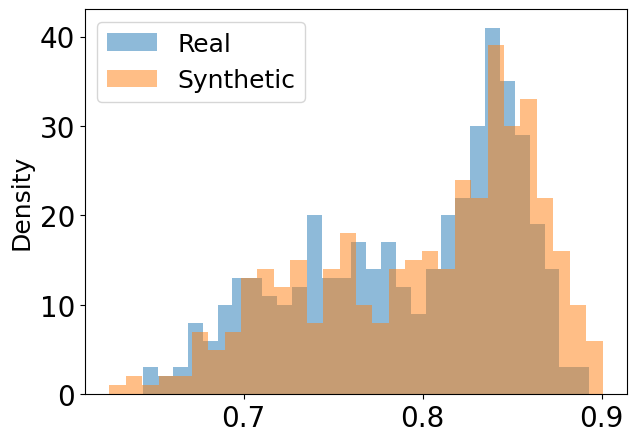

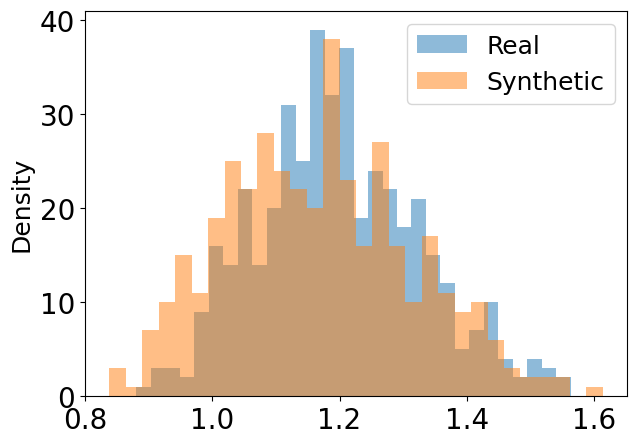

  Column  Chi2 Statistic  p-value
0    M/F             0.0      1.0


<Figure size 700x500 with 0 Axes>

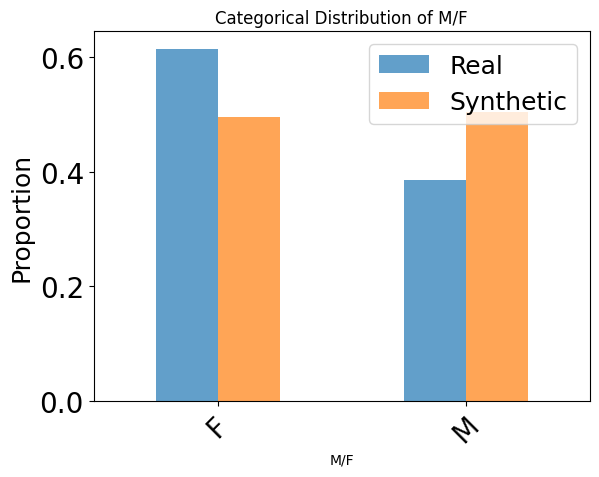

In [26]:
comp = TabularDataComparator(data, synthetic_data)

real_stats_2, synth_stats_2 = comp.summary_statistics()
print("Real Data Summary:\n", real_stats_2)
print("\nSynthetic Data Summary:\n", synth_stats_2)
print("\nKS Test Results:\n", comp.ks_test())

# Compare numeric
print(comp.ks_test())
comp.plot_distributions(name="model2")

# Compare categorical
print(comp.chi_square_test())
comp.plot_categorical(name="model2")

## DRAGAN

In [11]:
!pip install ydata-synthetic

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tensorflow-probability[tf] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.3/325.3 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 17.1 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 20.6 M

In [27]:
import pandas as pd
from sklearn import cluster

from ydata_synthetic.utils.cache import cache_file
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from ydata_synthetic.synthesizers.regular import RegularSynthesizer

#Define the Conditional GAN and training parameters
noise_dim = 32
dim = 128
batch_size = 128
beta_1 = 0.5
beta_2 = 0.9
log_step = 100

epochs = 3
learning_rate = 1e-4
model_parameters = ModelParameters(batch_size=batch_size,
                                   lr=learning_rate,
                                   betas=(beta_1, beta_2),
                                   noise_dim=noise_dim,
                                   layers_dim=dim)

#Test here the new inputs
gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           betas=(beta_1, beta_2),
                           noise_dim=noise_dim,
                           layers_dim=dim)

train_args = TrainParameters(epochs=epochs,
                             sample_interval=log_step)

#Init the Conditional GAN providing the index of the label column as one of the arguments
synth = RegularSynthesizer(modelname='dragan', model_parameters=model_parameters, n_discriminator=2)

#Training the Conditional GAN
synth.fit(data=data,  train_arguments = train_args, num_cols=numerical_columns, cat_cols=categorical_columns)

synthetic_data = synth.sample(400)

 33%|███▎      | 1/3 [00:01<00:02,  1.04s/it]

Epoch: 0 | disc_loss: 5.432610988616943 | gen_loss: -0.5682947635650635


 67%|██████▋   | 2/3 [00:01<00:00,  1.01it/s]

Epoch: 1 | disc_loss: 3.5104098320007324 | gen_loss: -0.5450518131256104


100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


Epoch: 2 | disc_loss: 2.0728721618652344 | gen_loss: -0.6241008043289185


Synthetic data generation: 100%|██████████| 4/4 [00:00<00:00, 205.90it/s]


Real Data Summary:
       count         mean         std       min         25%       50%  \
Age   436.0    51.357798   25.269862    18.000    23.00000    54.000   
eTIV  436.0  1481.919725  158.740866  1123.000  1367.75000  1475.500   
nWBV  436.0     0.791670    0.059937     0.644     0.74275     0.809   
ASF   436.0     1.198894    0.128682     0.881     1.11175     1.190   

             75%       max  skewness  kurtosis  
Age     74.00000    96.000 -0.000483 -1.598821  
eTIV  1579.25000  1992.000  0.266392 -0.154097  
nWBV     0.84200     0.893 -0.520533 -0.882832  
ASF      1.28425     1.563  0.286110 -0.179317  

Synthetic Data Summary:
       count         mean         std         min          25%          50%  \
Age   512.0    47.480469   15.700836   -1.000000    36.000000    47.000000   
eTIV  512.0  1216.333984  147.891230  704.000000  1118.000000  1206.000000   
nWBV  512.0     0.317724    0.060224    0.156466     0.273995     0.321058   
ASF   512.0     1.131492    0.135879

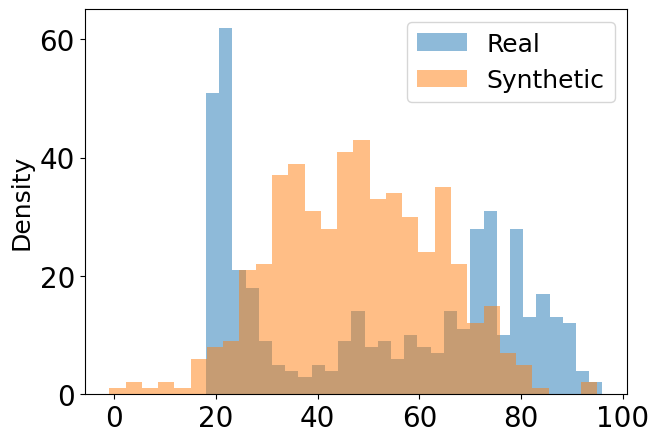

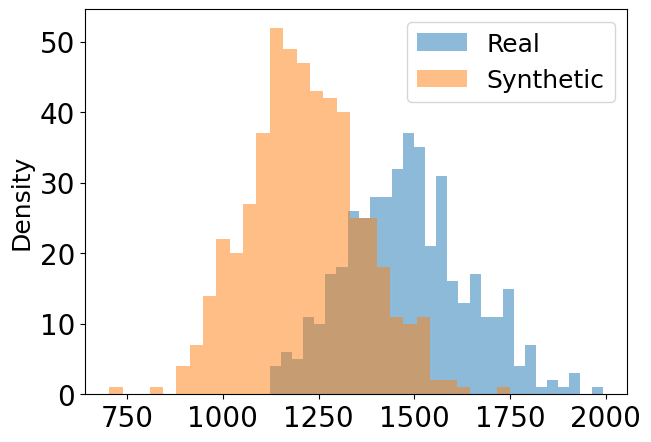

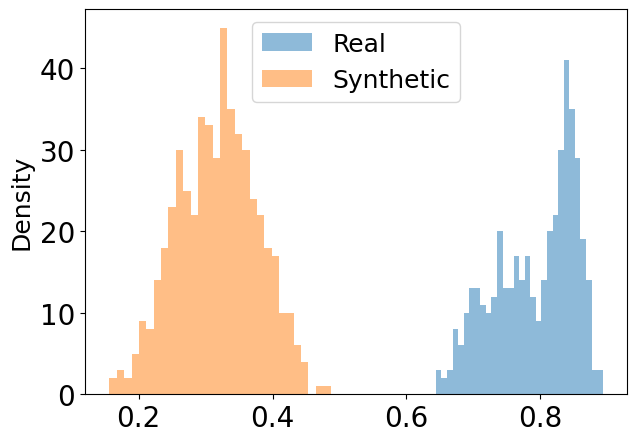

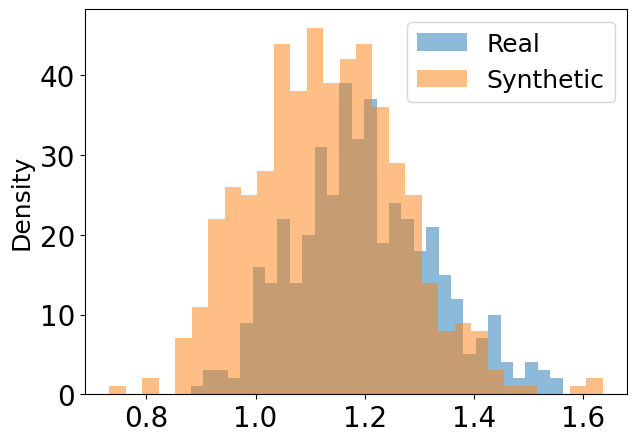

  Column  Chi2 Statistic  p-value
0    M/F             0.0      1.0


<Figure size 700x500 with 0 Axes>

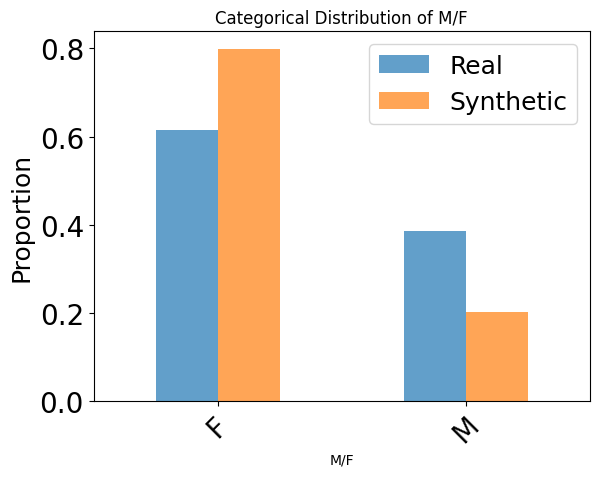

In [28]:
comp = TabularDataComparator(data, synthetic_data)

real_stats_3, synth_stats_3 = comp.summary_statistics()
print("Real Data Summary:\n", real_stats_3)
print("\nSynthetic Data Summary:\n", synth_stats_3)
print("\nKS Test Results:\n", comp.ks_test())

# Compare numeric
print(comp.ks_test())
comp.plot_distributions(name="model3")

# Compare categorical
print(comp.chi_square_test())
comp.plot_categorical(name="model3")